<a href="https://colab.research.google.com/github/kjahani/Awesome-Federated-Machine-Learning/blob/master/LinUCB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pylab as plt
np.random.seed(0)

In [2]:
class Environment(object):
    def __init__(self):
        self.theta = (-0.1, 0.2, 0.2)
        self.p = lambda arm: 0.2 + np.dot(self.theta, arm)

    def sample(self, arm):
        return 1 if np.random.random() < self.p(arm) else 0
    
    def best_arm(self, arms):
        return np.argmax([self.p(arm) for arm in arms])

In [3]:
class UCBAgent(object):
    def __init__(self):
        self.arms = [
            (1, 0, 0),
            (0, 1, 0),
            (1, 0, 1),
            (0, 1, 1)
        ]
        self.h = []
        self.T = []

    def get_ucbs(self):
        T = np.array(self.T)
        h = np.array(self.h)
        ucbs = [(
            np.mean(T[h==arm_idx]) +
            np.sqrt(2 * np.log(len(T)) / len(T[h==arm_idx])))
            if len(T[h==arm_idx]) > 0 else np.inf
            for arm_idx, arm in enumerate(self.arms)]
        return ucbs
    
    def learn(self):
        ucbs = self.get_ucbs()
        arm_idx = ucbs.index(max(ucbs))
        return self.arms[arm_idx]
    
    def sample(self, t, arm):
        arm_idx = self.arms.index(arm)
        self.T.append(t)
        self.h.append(arm_idx)

In [4]:
class LinUCBAgent(object):
    def __init__(self):
        self.arms = [
            (1, 0, 0),
            (0, 1, 0),
            (1, 0, 1),
            (0, 1, 1)
        ]
        self.h = []
        self.T = []
        self.alpha = 2
        self.A = np.identity(3)
        self.b = np.atleast_2d(np.zeros(3)).T

    def get_ucbs(self):
        T = np.array(self.T)
        h = np.array(self.h)
        theta = np.dot(np.linalg.inv(self.A), self.b)
        ucbs = []
        for arm in self.arms:
            arm = np.atleast_2d(arm).T
            ucb = np.dot(theta.T, arm)
            ucb += self.alpha * np.sqrt(np.dot(arm.T, np.dot(np.linalg.inv(self.A), arm)))
            ucbs.append(ucb[0][0])
        return ucbs
    
    def learn(self):        
        ucbs = self.get_ucbs()
        return self.arms[ucbs.index(max(ucbs))]
    
    def sample(self, t, arm):
        arm_idx = self.arms.index(arm)
        self.T.append(t)
        self.h.append(arm_idx)
        self.update(arm, t)
    
    def update(self, arm, t):
        arm = np.atleast_2d(arm).T
        self.A += np.dot(arm, arm.T)
        self.b += t * arm

In [5]:
ucb_agents = []
linucb_agents = []
env = Environment()
for sim in range(100):
    agent = UCBAgent()
    for i in range(1000):
        arm = agent.learn()
        reward = env.sample(arm)
        agent.sample(reward, arm)
    ucb_agents.append(agent)

    agent = LinUCBAgent()
    for i in range(1000):
        arm = agent.learn()
        reward = env.sample(arm)
        agent.sample(reward, arm)
    linucb_agents.append(agent)

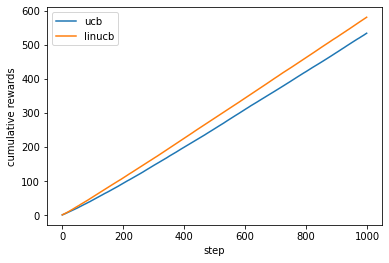

In [6]:
plt.plot(np.cumsum(np.mean(np.array([agent.T for agent in ucb_agents]), axis=0)), label='ucb')
plt.plot(np.cumsum(np.mean(np.array([agent.T for agent in linucb_agents]), axis=0)), label='linucb')
plt.xlabel('step')
plt.ylabel('cumulative rewards')
plt.legend()

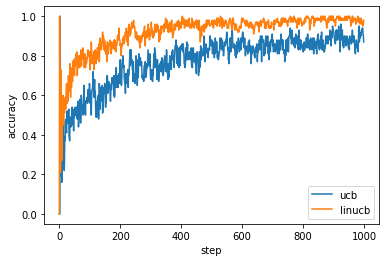

In [7]:
best_arm = env.best_arm(ucb_agents[0].arms)
plt.plot(np.mean(np.array([agent.h for agent in ucb_agents])==best_arm, axis=0), label='ucb')
plt.plot(np.mean(np.array([agent.h for agent in linucb_agents])==best_arm, axis=0), label='linucb')
plt.xlabel('step')
plt.ylabel('accuracy')
plt.legend()